In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from google.colab import files


In [ ]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle
# Upload Kaggle API key file (might have to rerun to work)
files.upload()

# Download the dataset
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip it
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
# Set data directory
data_dir = "/content"

# Load metadata
df_meta = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))

# Select only the required classes: 'df', 'vasc', 'akiec'
selected_classes = ['df', 'vasc', 'akiec']
df_meta = df_meta[df_meta['dx'].isin(selected_classes)].reset_index(drop=True)

# Collect all image paths from both directories
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in image_paths
}

# Map image paths to the metadata dataframe
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)

# Check for missing paths
if df_meta['path'].isnull().any():
    print("Some images are missing from the provided directories!")
    missing_ids = df_meta[df_meta['path'].isnull()]['image_id'].tolist()
    print(f"Missing image IDs: {missing_ids}")

# Map categorical labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(selected_classes)}
df_meta['label'] = df_meta['dx'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df_meta, stratify=df_meta['label'], test_size=0.2, random_state=42)

In [ ]:
# Augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
augmented_dir = os.path.join(data_dir, "augmented_images")
os.makedirs(augmented_dir, exist_ok=True)

def augment_and_save_images(df, imgs_to_generate=500):
    augmented_data = []

    for class_label in df['label'].unique():
        class_data = df[df['label'] == class_label]
        img_count = len(class_data)

        for i in range(imgs_to_generate):
            img_path = class_data.iloc[i % img_count]['path']
            img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augmented_images = datagen.flow(img_array, batch_size=1)
            for aug_img in augmented_images:
                save_path = os.path.join(augmented_dir, f"{class_label}_{i}.jpg")
                tf.keras.preprocessing.image.save_img(save_path, aug_img[0])
                augmented_data.append((save_path, class_label))
                break

    return pd.DataFrame(augmented_data, columns=['path', 'label'])

In [ ]:
# Augment training data
augmented_train_df = augment_and_save_images(train_df)

# Combine augmented data with original training data
train_df_combined = pd.concat([train_df[['path', 'label']], augmented_train_df], ignore_index=True)

# Convert 'label' column to string
train_df_combined['label'] = train_df_combined['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [ ]:
# Prepare data generators for training and validation
train_gen = datagen.flow_from_dataframe(
    train_df_combined,
    x_col='path',
    y_col='label',
    target_size=(299, 299),
    class_mode='categorical',
    batch_size=32
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(299, 299),
    class_mode='categorical',
    batch_size=32
)


Found 1967 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
# Model architecture with InceptionV3
base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
import os
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Load the checkpoint model if it exists
checkpoint_to_load = "/content/manual_model_epoch_75.h5"
if os.path.exists(checkpoint_to_load):
    print(f"Loading model from {checkpoint_to_load}")
    model = load_model(checkpoint_to_load)
else:
    print("Checkpoint not found. Proceeding with untrained model.")

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint and learning rate reduction callbacks
checkpoint_dir = os.path.join(data_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Load the previous history if it exists
history_dir = os.path.join(data_dir, "history_files")
os.makedirs(history_dir, exist_ok=True)

history_file = os.path.join(history_dir, 'train_history.pkl')

# Load the history file from the specified path
history_to_load = "/content/train_history_epoch_75.pkl"
if os.path.exists(history_to_load):
    print(f"Loading training history from {history_to_load}")
    with open(history_to_load, 'rb') as f:
        saved_history = pickle.load(f)
else:
    print("Training history not found. Proceeding with empty history.")
    saved_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Save the history
def save_history(history, epoch):
    session_history_file = os.path.join(history_dir, f'train_history_epoch_{epoch}.pkl')
    with open(session_history_file, 'wb') as f:
        pickle.dump(history, f)
    print(f"History saved at: {session_history_file}")

# Define training parameters
initial_epoch = len(saved_history['accuracy'])  # Continue from the last saved epoch
print(f"Initial epoch set to: {initial_epoch}")

total_epochs = 200
epochs_per_session = 15

# Train in increments of epochs
while initial_epoch < total_epochs:
    print(f"Starting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    # Train the model for the current session
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr]
    )

    # Load previous history and save only available keys
    for key in history.history:
        if key in saved_history:
            saved_history[key].extend(history.history[key])
        else:
            saved_history[key] = history.history[key]

    save_history(saved_history, initial_epoch + epochs_per_session)

    # Save the model manually after every session
    model_save_path = os.path.join(checkpoint_dir, f"manual_model_epoch_{initial_epoch + epochs_per_session}.h5")
    model.save(model_save_path)
    print(f"Model manually saved at: {model_save_path}")

    # Update initial epoch for the next session
    initial_epoch += epochs_per_session

    print(f"Completed {initial_epoch} epochs. You can now switch to another session and resume training.")

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Loading model from /content/manual_model_epoch_75.h5
Loading training history from /content/train_history_epoch_75.pkl
Initial epoch set to: 75
Starting training from epoch 75 to 90
Epoch 76/90
62/62 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.5191
Epoch 76: val_loss improved from inf to 0.82610, saving model to /content/checkpoints/model_epoch_076_val_loss_0.8261.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 308s 5s/step - loss: 0.9677 - accuracy: 0.5191 - val_loss: 0.8261 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 77/90
62/62 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.5175
Epoch 77: val_loss did not improve from 0.82610
62/62 [==============================] - 296s 5s/step - loss: 0.9714 - accuracy: 0.5175 - val_loss: 0.8366 - val_accuracy: 0.6752 - lr: 0.0010
Epoch 78/90
62/62 [==============================] - ETA: 0s - loss: 0.9553 - accuracy: 0.5358
Epoch 78: val_loss did not improve from 0.82610
62/62 [==============================] - 297s 5s/step - loss: 0.9553 - accuracy: 0.5358 - val_loss: 0.8598 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 79/90
62/62 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.5165
Epoch 79: val_loss did not improve from 0.82610
62/62 [==============================] - 298s 5s/step - loss: 0.9751 - accuracy: 0.5165 - val_loss: 0.8990 - val_accuracy: 0.7094 - lr: 0.0010

KeyboardInterrupt: 

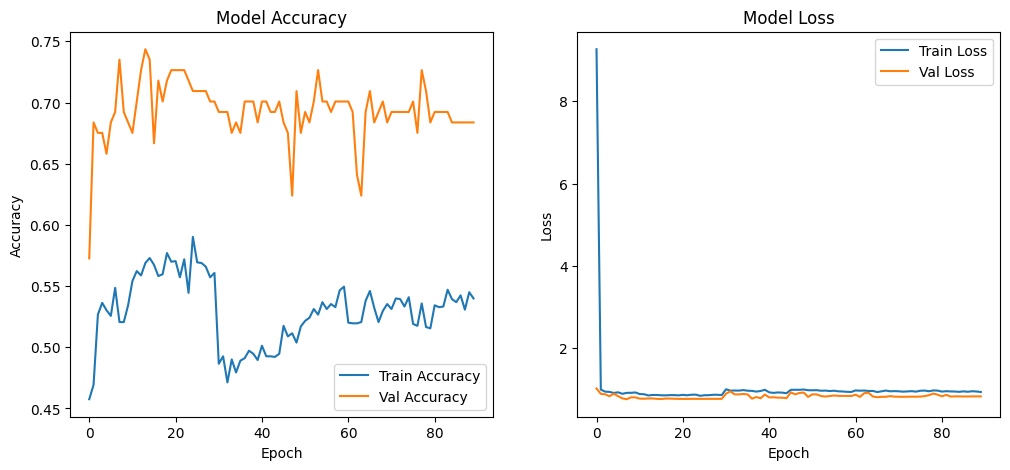

In [ ]:
# Plot the final history
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
